In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline
import theano.tensor as T
import scipy.stats as stats

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '12740' (I am process '16164')
C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [22]:
"""Code 2.2"""
# p(observed_data | probability of our thumb landing on Water 6 times out of 9 tries)
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000006

# Grid Approximation

In [40]:
"""Code 2.3"""
def posterior_grid_approx(grid_points=5, success=6, tosses=9):

    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform probability at all grid_points
    #prior = (p_grid >= 0.5).astype(int)  # truncated
    #prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

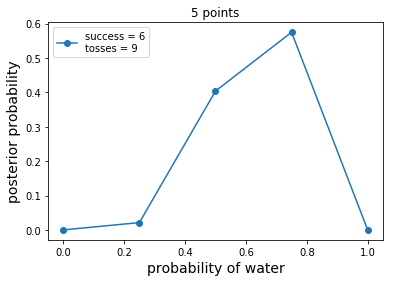

In [41]:
points = 5
w, n = 6, 9
p_grid, posterior = posterior_grid_approx(points, w, n)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

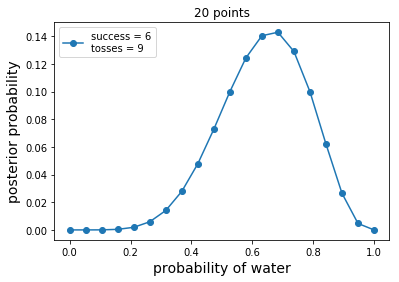

In [16]:
points = 20
w, n = 6, 9
p_grid, posterior = posterior_grid_approx(points, w, n)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

In [17]:
"""Code 2.5"""
def posterior_grid_approx(grid_points=5, success=6, tosses=9):
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    #prior = np.repeat(5, grid_points)  # uniform probability at all grid_points
    prior = (p_grid >= 0.5).astype(int)  # truncated (0 if smaller than 0.5; else 1. Meaning prior is uniform only from 0.5-1)
    #prior = np.exp(- 20 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

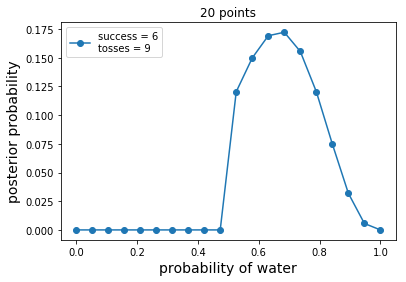

In [18]:
points = 20
w, n = 6, 9
p_grid, posterior = posterior_grid_approx(points, w, n)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

In [19]:
"""Code 2.5"""
def posterior_grid_approx(grid_points=5, success=6, tosses=9):
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    #prior = np.repeat(5, grid_points)  # uniform probability at all grid_points
    #prior = (p_grid >= 0.5).astype(int)  # truncated (0 if smaller than 0.5; else 1. Meaning prior is uniform only from 0.5-1)
    prior = np.exp(- 20 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

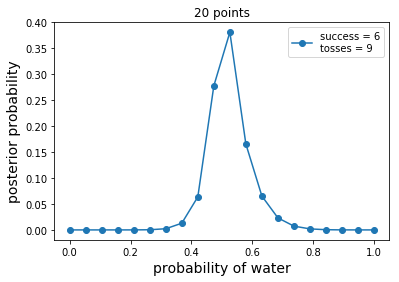

In [171]:
points = 20
w, n = 6, 9
p_grid, posterior = posterior_grid_approx(points, w, n)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

# Quadratic Approximation

In [231]:
"""Code 2.6"""
# Computing the posterior using the quadratic approximation. It does two things: 1) finds the peak of
# the posterior (mode), and 2) calculates the curvature near the peak to compute the approximation of the posterior distribution
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_approximation:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=len(data), p=p, observed=data.sum())
    mean_q = pm.find_MAP() #find peak of the posterior distribution (its mode), which always uses a GAUSSIAN
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]

logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 1390.62it/s]


In [232]:
print("The mode of the posterior (MAP) is: (this is the mean of the Guassian used to calculate the NAP)")
print(mean_q['p'])
print("\nThe curvature at its peak is: (this is the std of the Guassian used to calculate the curvature)")
print(std_q)

The mode of the posterior (MAP) is: (this is the mean of the Guassian used to calculate the NAP)
0.6666666671652423

The curvature at its peak is: (this is the std of the Guassian used to calculate the curvature)
[0.15713484]


In [233]:
norm = stats.norm(mean_q, std_q)
prob = .89
z = stats.norm.ppf([(1-prob)/2, (1+prob)/2])
pi = mean_q['p'] + std_q * z 

print("The 89th percentile interval is:")
pi

The 89th percentile interval is:


array([0.41553484, 0.91779849])

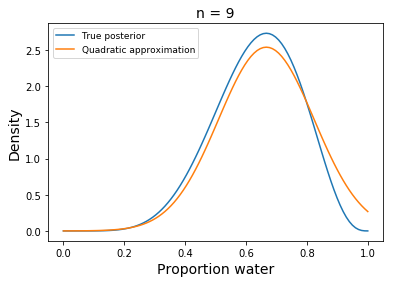

In [234]:
"""Code 2.7"""
# analytical calculation (beta/binomial conjugate)
w, n = 6, 9
x = np.linspace(0, 1, 100)

# Here we're using beta posterior distribution to do the plot because the beta is the conjugate prior of the 
# binomial: beta(1,1) is the uniform prior for the binomial data, resulting in:  
plt.plot(x, stats.beta.pdf(x , w+1, n-w+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),
         label='Quadratic approximation')
plt.legend(loc=0, fontsize=9)

plt.title('n = {}'.format(n), fontsize=14)
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);

In [228]:
"""Code 2.6 (my addition)"""
#changed to n=180 (60 zeros or no water, and 120 ones or landing on water)
data = np.repeat((0, 1), (60, 120))

with pm.Model() as normal_approximation:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=len(data), p=p, observed=data.sum())
    mean_q = pm.find_MAP() #find peak of the posterior distribution (its mode), which always uses a GAUSSIAN
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]

logp = -12.959, ||grad|| = 30: 100%|███████████| 7/7 [00:00<00:00, 1999.87it/s]


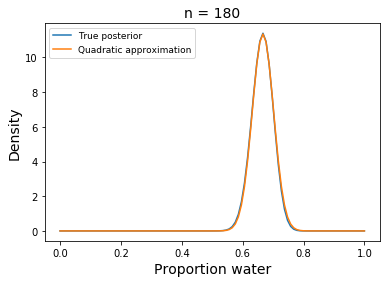

In [229]:
"""Code 2.7 (my addition)"""
# changed to higher count 
w, n = 120, 180
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , w+1, n-w+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),
         label='Quadratic approximation')
plt.legend(loc=0, fontsize=9)

plt.title('n = {}'.format(n), fontsize=14)
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);

We see above that more data means better quadratic approximation of the true `p` 

In [227]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer AMD64 running   and using:
Python 3.6.4
IPython 6.2.1
PyMC3 3.3
NumPy 1.14.0
SciPy 1.0.0
Matplotlib 2.1.2

